<a href="https://colab.research.google.com/github/ernstmargo/anomaly-detection/blob/main/SVM_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import and read data

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import ipaddress 
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split


In [2]:
pip install memory_profiler

  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=78d899fa7bd9ebd046b6da6b802e578bfb0620f7f7dc137239c5faa640d24d64
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler


Read Wednesday dataset or Full dataset 

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/full_dataset')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,1,3,6,84) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df_w=pd.read_csv('/content/drive/MyDrive/Dataset/Wednesday-workingHours.pcap_ISCX.csv')


#Preprocessing 





In [5]:
def format_name(columns):
  col= []
  for x in columns:
        x=x.strip().lower().replace(' ', '_').replace('/', '_').replace('.', '_')
        col.append(x)
  return col
  
def ip_to_int(ip):
   new_ip=int(ipaddress.ip_address(ip))
   return new_ip

def rename_lables(df):
    df=df.replace({'label': {'DoS slowloris':'DOS','DoS Slowhttptest':'DOS', 'DoS Hulk':'DOS', 'DoS GoldenEye':'DOS', 'Heartbleed':'DOS', 'DDOS':'DOS'}})
    df.loc[ df['label'] !='DOS', 'label'] = 'BENIGN'
    df=df.replace({'label': {'BENIGN':0, 'DOS':1}})
    label_unique=df['label'].unique()
    k=0
    for x in label_unique:
        df=df.replace({'label': {x:k}})
        k=k+1
    return df

def preprocessing(df):
  df.columns=format_name(df.columns)
  df=df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
  df['timestamp'] = pd.to_datetime(df['timestamp'])
  df['timestamp'] = df['timestamp'].values.astype('float')
  df['source_ip']=df['source_ip'].apply(ip_to_int)
  df['destination_ip']=df['destination_ip'].apply(ip_to_int)
  df=df.drop(columns=['flow_id'])
  df=rename_lables(df)
  y=df['label'].astype(int)
  x=df.drop(columns=['label'])
  return df, x, y
  


In [6]:
df_preproc, x, y=preprocessing(df_w) 
# here df or df_w is chosen and determens if the test run is for Full or Wednesday dataset

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9, random_state=42, shuffle=True)
#train/test split for feature selection 


#Scale

In [8]:
from sklearn.preprocessing import scale
from sklearn import preprocessing


In [9]:
x_scaled=scale(x) # Standard scale 

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:236: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  "Numerical issues were encountered "


In [10]:
min_max_scaler = preprocessing.MinMaxScaler() # MinMax Scaling
x_min_max=min_max_scaler.fit_transform(x)
x_train_min_max=min_max_scaler.fit_transform(x_train)


In [11]:
max_abs_scaler=preprocessing.MaxAbsScaler() # MaxAbs Scaling
x_max_abs=max_abs_scaler.fit_transform(x)

#Fearture Selection

### Select best 

In [12]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif

In [13]:
selectkbest_chi = SelectKBest(chi2, k=20).fit(x_train_min_max, y_train)
x_min_max_selectkbest_chi = selectkbest_chi.transform(x_min_max)

In [14]:
col_index=selectkbest_chi.get_support()

###PCA

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [16]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_min_max)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [17]:
finalDf = pd.concat([principalDf, y], axis = 1)
finalDf.shape

(692703, 3)

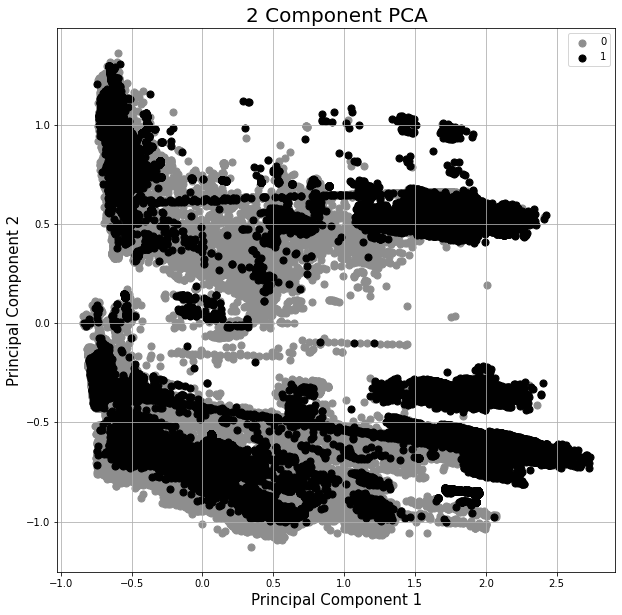

In [18]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = [0,1]
colors = ['#8e8e8e', '#010101']
markers = ["o", "o"]
for target, color, marker in zip(targets,colors,markers):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50,
               marker = marker)
ax.legend(targets)
ax.grid()

# SVM implementation


In [19]:
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support,precision_score, recall_score, f1_score, classification_report

In [20]:
def class_SVM(x,y, kernel):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.95, random_state=42, shuffle=True)
    clf=svm.LinearSVC() if kernel=="linear" else svm.SVC()
    clf.fit(x_train, y_train)
    y_pred=clf.predict(x_test)
    print(classification_report(y_test, y_pred, digits=4))
    return y_pred, x_test, y_test

In [21]:
%load_ext memory_profiler

## SVM with RBF

In [24]:
%%time
%memit
y_pred_scaled_all, x_test, y_test=class_SVM(x_scaled, y, "rbf")

peak memory: 7889.55 MiB, increment: 0.00 MiB
              precision    recall  f1-score   support

           0     0.9998    0.9994    0.9996    417803
           1     0.9990    0.9996    0.9993    239033

    accuracy                         0.9995    656836
   macro avg     0.9994    0.9995    0.9994    656836
weighted avg     0.9995    0.9995    0.9995    656836

CPU times: user 1min 37s, sys: 766 ms, total: 1min 37s
Wall time: 1min 38s


In [26]:
from sklearn.metrics import confusion_matrix
cf_matrix=confusion_matrix(y_test, y_pred_scaled_all)
cf_matrix

array([[417556,    247],
       [    91, 238942]])

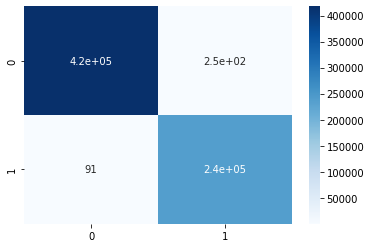

In [27]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

In [28]:
%%time
%memit
y_pred_min_max, x_test, y_test=class_SVM(x_min_max, y, "rbf")

peak memory: 8065.36 MiB, increment: 0.04 MiB
              precision    recall  f1-score   support

           0     0.9977    0.9970    0.9974    417803
           1     0.9947    0.9960    0.9954    239033

    accuracy                         0.9966    656836
   macro avg     0.9962    0.9965    0.9964    656836
weighted avg     0.9966    0.9966    0.9966    656836

CPU times: user 1min 43s, sys: 442 ms, total: 1min 44s
Wall time: 1min 44s


In [29]:
%%time
%memit
y_pred_max_aabs, x_test, y_test=class_SVM(x_max_abs, y, "rbf")

peak memory: 8099.68 MiB, increment: 0.00 MiB
              precision    recall  f1-score   support

           0     0.9963    0.9949    0.9956    417803
           1     0.9911    0.9935    0.9923    239033

    accuracy                         0.9944    656836
   macro avg     0.9937    0.9942    0.9940    656836
weighted avg     0.9944    0.9944    0.9944    656836

CPU times: user 2min 9s, sys: 445 ms, total: 2min 10s
Wall time: 2min 9s


In [30]:
%%time
%memit
y_pred_selectbest_20, x_test, y_test=class_SVM(x_min_max_selectkbest_chi, y, "rbf")

peak memory: 8106.77 MiB, increment: 0.00 MiB
              precision    recall  f1-score   support

           0     0.8569    0.9811    0.9148    417803
           1     0.9557    0.7136    0.8171    239033

    accuracy                         0.8837    656836
   macro avg     0.9063    0.8473    0.8659    656836
weighted avg     0.8928    0.8837    0.8792    656836

CPU times: user 7min 48s, sys: 642 ms, total: 7min 49s
Wall time: 7min 47s


In [31]:
%%time
%memit
y_pred_pca, x_test, y_test=class_SVM(principalComponents, y, "rbf")

peak memory: 8178.36 MiB, increment: 0.00 MiB
              precision    recall  f1-score   support

           0     0.9827    0.9073    0.9435    417803
           1     0.8571    0.9721    0.9110    239033

    accuracy                         0.9309    656836
   macro avg     0.9199    0.9397    0.9273    656836
weighted avg     0.9370    0.9309    0.9317    656836

CPU times: user 5min 5s, sys: 582 ms, total: 5min 6s
Wall time: 5min 5s


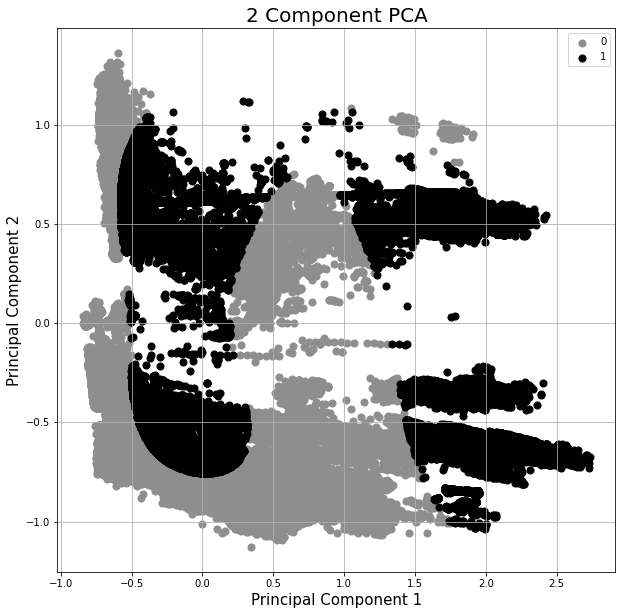

In [32]:
principalDf = pd.DataFrame(data = x_test
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, y_test], axis = 1)
finalDf.shape


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = [0,1]
colors = ['#8e8e8e', '#010101']

for target, color in zip(targets,colors):
    indicesToKeep = y_pred_pca == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']              
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

plt.show()

## SVM with Linear

In [33]:
%%time
%memit
y_pred_scaled_all, x_test, y_test=class_SVM(x_scaled, y, "linear")

peak memory: 8251.73 MiB, increment: 0.00 MiB


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


              precision    recall  f1-score   support

           0     0.9999    0.9997    0.9998    417803
           1     0.9995    0.9999    0.9997    239033

    accuracy                         0.9998    656836
   macro avg     0.9997    0.9998    0.9998    656836
weighted avg     0.9998    0.9998    0.9998    656836

CPU times: user 5.36 s, sys: 645 ms, total: 6.01 s
Wall time: 5.7 s


In [39]:
from sklearn.metrics import confusion_matrix
cf_matrix=confusion_matrix(y_test, y_pred_scaled_all)
cf_matrix

array([[417694,    109],
       [    31, 239002]])

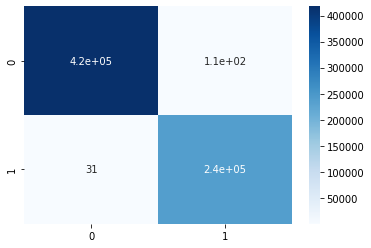

In [40]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True, cmap='Blues')

In [41]:
%%time
%memit
y_pred_min_max, x_test, y_test=class_SVM(x_min_max, y, "linear")

peak memory: 8342.20 MiB, increment: 0.01 MiB
              precision    recall  f1-score   support

           0     0.9987    0.9964    0.9975    417803
           1     0.9937    0.9977    0.9957    239033

    accuracy                         0.9968    656836
   macro avg     0.9962    0.9970    0.9966    656836
weighted avg     0.9968    0.9968    0.9968    656836

CPU times: user 3.89 s, sys: 658 ms, total: 4.55 s
Wall time: 4.21 s


In [35]:
%%time
%memit
y_pred_max_aabs, x_test, y_test=class_SVM(x_max_abs, y, "linear")

peak memory: 8300.08 MiB, increment: 0.01 MiB
              precision    recall  f1-score   support

           0     0.9952    0.9962    0.9957    417803
           1     0.9933    0.9916    0.9924    239033

    accuracy                         0.9945    656836
   macro avg     0.9942    0.9939    0.9941    656836
weighted avg     0.9945    0.9945    0.9945    656836

CPU times: user 3.26 s, sys: 626 ms, total: 3.89 s
Wall time: 3.6 s


In [36]:
%%time
%memit
y_pred_selectbest_20, x_test, y_test=class_SVM(x_min_max_selectkbest_chi, y, "linear")

peak memory: 8299.85 MiB, increment: 0.02 MiB
              precision    recall  f1-score   support

           0     0.8363    0.9917    0.9074    417803
           1     0.9784    0.6608    0.7888    239033

    accuracy                         0.8712    656836
   macro avg     0.9074    0.8262    0.8481    656836
weighted avg     0.8880    0.8712    0.8642    656836

CPU times: user 2.71 s, sys: 624 ms, total: 3.34 s
Wall time: 3.13 s


In [37]:
%%time
%memit
y_pred_pca, x_test, y_test=class_SVM(principalComponents, y, "linear")

peak memory: 8299.85 MiB, increment: 0.00 MiB
              precision    recall  f1-score   support

           0     0.7988    0.9593    0.8717    417803
           1     0.8904    0.5777    0.7007    239033

    accuracy                         0.8204    656836
   macro avg     0.8446    0.7685    0.7862    656836
weighted avg     0.8321    0.8204    0.8095    656836

CPU times: user 2.04 s, sys: 600 ms, total: 2.64 s
Wall time: 2.47 s


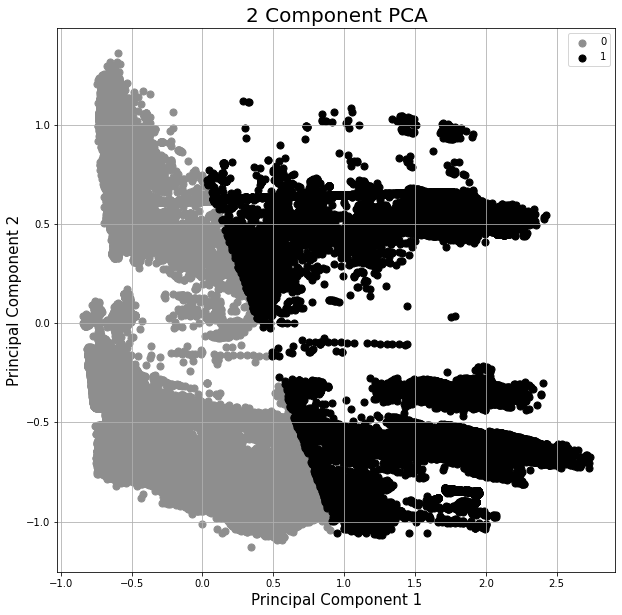

In [38]:
principalDf = pd.DataFrame(data = x_test
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, y_test], axis = 1)
finalDf.shape


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = [0,1]
colors = ['#8e8e8e', '#010101']

for target, color in zip(targets,colors):
    indicesToKeep = y_pred_pca == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']              
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

plt.show()